### 基于信贷数据进行用户信贷分类，使用Logistic算法和KNN算法构建模型，并比较这两大类算法的效果

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import sklearn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model.coordinate_descent import ConvergenceWarning
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
## 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif']=[u'simHei']
mpl.rcParams['axes.unicode_minus']=False
## 拦截异常
warnings.filterwarnings(action = 'ignore', category=ConvergenceWarning)

In [4]:
### 加载数据并对数据进行预处理
# 1. 加载数据
path = "datas/crx.data"
names = ['A1','A2','A3','A4','A5','A6','A7','A8',
         'A9','A10','A11','A12','A13','A14','A15','A16']
df = pd.read_csv(path, header=None, names=names)
print("数据条数:", len(df))

# 2. 异常数据过滤
df = df.replace("?", np.nan).dropna(how='any')
print("过滤后数据条数:", len(df))

df.head(5)

数据条数: 690
过滤后数据条数: 653


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [5]:


def parse(v, l):
    return [1 if i == v else 0 for i in l]
def parseRecord(record):
    result = []
    ## 格式化数据，将离线数据转换为连续数据
    a1 = record['A1']
    for i in parse(a1, ('a', 'b')):
        result.append(i)
    
    result.append(float(record['A2']))
    result.append(float(record['A3']))
    
    
    a4 = record['A4']
    for i in parse(a4, ('u', 'y', 'l', 't')):
        result.append(i)
    
    a5 = record['A5']
    for i in parse(a5, ('g', 'p', 'gg')):
        result.append(i)
    
    a6 = record['A6']
    for i in parse(a6, ('c', 'd', 'cc', 'i', 'j', 'k', 'm', 'r', 'q', 'w', 'x', 'e', 'aa', 'ff')):
        result.append(i)
    
    a7 = record['A7']
    for i in parse(a7, ('v', 'h', 'bb', 'j', 'n', 'z', 'dd', 'ff', 'o')):
        result.append(i)
    
    result.append(float(record['A8']))
    
    a9 = record['A9']
    for i in parse(a9, ('t', 'f')):
        result.append(i)
        
    a10 = record['A10']
    for i in parse(a10, ('t', 'f')):
        result.append(i)
    
    result.append(float(record['A11']))
    
    a12 = record['A12']
    for i in parse(a12, ('t', 'f')):
        result.append(i)
        
    a13 = record['A13']
    for i in parse(a13, ('g', 'p', 's')):
        result.append(i)
    
    result.append(float(record['A14']))
    result.append(float(record['A15']))
    
    a16 = record['A16']
    if a16 == '+':
        result.append(1)
    else:
        result.append(0)
        
    return result

In [6]:
### 数据特征处理(将数据转换为数值类型的)
new_names =  ['A1_0', 'A1_1',
              'A2','A3',
              'A4_0','A4_1','A4_2','A4_3',
              'A5_0', 'A5_1', 'A5_2', 
              'A6_0', 'A6_1', 'A6_2', 'A6_3', 'A6_4', 'A6_5', 'A6_6', 'A6_7', 'A6_8', 'A6_9', 'A6_10', 'A6_11', 'A6_12', 'A6_13', 
              'A7_0', 'A7_1', 'A7_2', 'A7_3', 'A7_4', 'A7_5', 'A7_6', 'A7_7', 'A7_8', 
              'A8',
              'A9_0', 'A9_1' ,
              'A10_0', 'A10_1',
              'A11',
              'A12_0', 'A12_1',
              'A13_0', 'A13_1', 'A13_2',
              'A14','A15','A16']
datas = df.apply(lambda x: pd.Series(parseRecord(x), index = new_names), axis=1)
names = new_names

## 展示一下处理后的数据
datas.head(5)

,A1_0,A1_1,A2,A3,A4_0,A4_1,A4_2,A4_3,A5_0,A5_1,...,A10_1,A11,A12_0,A12_1,A13_0,A13_1,A13_2,A14,A15,A16
0,0.0,1.0,30.83,0.000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,202.0,0.0,1.0
1,1.0,0.0,58.67,4.460,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,6.0,0.0,1.0,1.0,0.0,0.0,43.0,560.0,1.0
2,1.0,0.0,24.50,0.500,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,280.0,824.0,1.0
3,0.0,1.0,27.83,1.540,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,5.0,1.0,0.0,1.0,0.0,0.0,100.0,3.0,1.0
4,0.0,1.0,20.17,5.625,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,120.0,0.0,1.0


In [7]:
## 数据分割
X = datas[names[0:-1]]
Y = datas[names[-1]]

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.1,random_state=0)

In [8]:
## 数据正则化操作(归一化)
ss = StandardScaler()
X_train = ss.fit_transform(X_train) ## 训练正则化模型，并将训练数据归一化操作
X_test = ss.fit_transform(X_test) ## 使用训练好的模型对测试数据进行归一化操作

In [9]:
## Logistic算法模型构建
lr = LogisticRegressionCV(Cs=np.logspace(-4,1,50), fit_intercept=True, penalty='l2', solver='lbfgs', tol=0.01, multi_class='ovr')
lr.fit(X_train, Y_train)

LogisticRegressionCV(Cs=array([  1.00000e-04,   1.26486e-04,   1.59986e-04,   2.02359e-04,
         2.55955e-04,   3.23746e-04,   4.09492e-04,   5.17947e-04,
         6.55129e-04,   8.28643e-04,   1.04811e-03,   1.32571e-03,
         1.67683e-03,   2.12095e-03,   2.68270e-03,   3.39322e-03,
         4.29193e-03,   5.428...     3.08884e+00,   3.90694e+00,   4.94171e+00,   6.25055e+00,
         7.90604e+00,   1.00000e+01]),
           class_weight=None, cv=None, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.01, verbose=0)

In [11]:
## Logistic算法效果输出
lr_r = lr.score(X_train, Y_train)
print("Logistic算法R值（准确率）：", lr_r)
print("Logistic算法稀疏化特征比率：%.2f%%" % (np.mean(lr.coef_.ravel() == 0) * 100))
print("Logistic算法参数：",lr.coef_)
print("Logistic算法截距：",lr.intercept_)

Logistic算法R值（准确率）： 0.890971039182
Logistic算法稀疏化特征比率：2.13%
Logistic算法参数： [[-0.00507672  0.00507672  0.06367298  0.06284643  0.03997945 -0.04935683
   0.06679464  0.          0.03997945 -0.04935683  0.06679464  0.00549457
  -0.02646873  0.1057865  -0.10294239 -0.02346199 -0.05981958 -0.0131902
   0.01148842  0.04690591  0.03631018  0.13996153  0.03858644 -0.02422956
  -0.11817039 -0.00441403  0.08130739 -0.02489682  0.03130081  0.03567533
  -0.01396069 -0.00769375 -0.10417126 -0.00379776  0.15834772  0.46892613
  -0.46892613  0.16546747 -0.16546747  0.19117654 -0.01273762  0.01273762
   0.01240825 -0.00744574 -0.0110668  -0.08907636  0.12989149]]
Logistic算法截距： [-0.25992008]


In [12]:
## Logistic算法预测
lr_y_predict = lr.predict(X_test)

In [13]:
## KNN算法构建
knn = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree', weights='distance')
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance')

In [15]:
## KNN算法效果输出
knn_r = knn.score(X_train, Y_train)
print("Logistic算法R值（准确率）：", knn_r)

Logistic算法R值（准确率）： 1.0


In [16]:
## KNN算法预测
knn_y_predict = knn.predict(X_test)

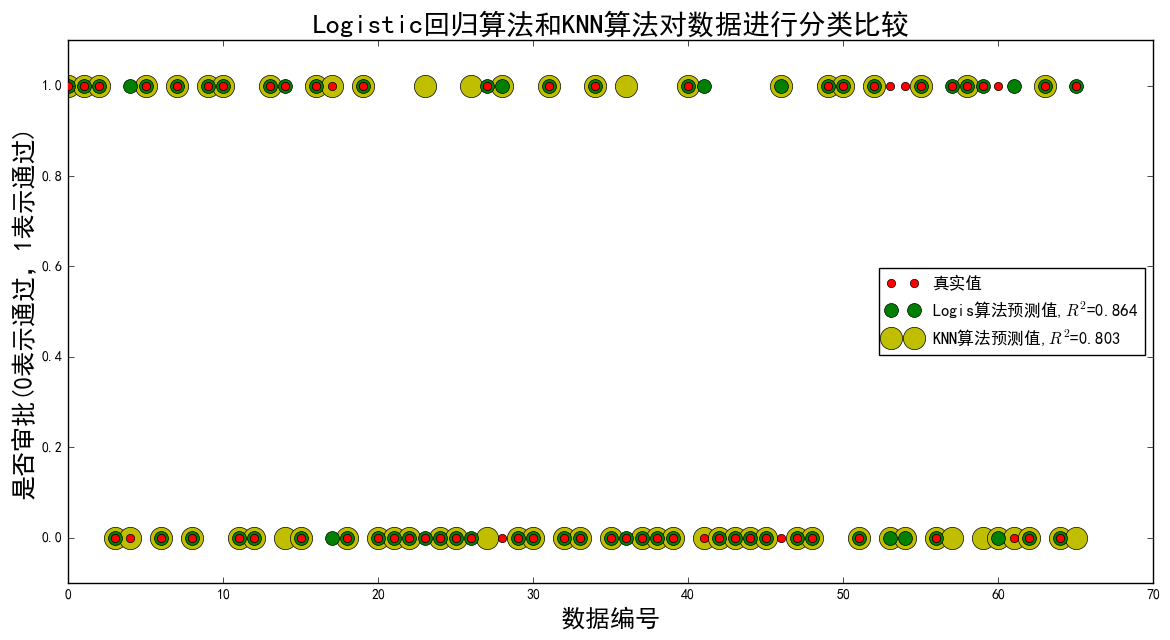

In [17]:
## 结果图像展示
## c. 图表展示
x_len = range(len(X_test))
plt.figure(figsize=(14,7), facecolor='w')
plt.ylim(-0.1,1.1)
plt.plot(x_len, Y_test, 'ro',markersize = 6, zorder=3, label=u'真实值')
plt.plot(x_len, lr_y_predict, 'go', markersize = 10, zorder=2, label=u'Logis算法预测值,$R^2$=%.3f' % lr.score(X_test, Y_test))
plt.plot(x_len, knn_y_predict, 'yo', markersize = 16, zorder=1, label=u'KNN算法预测值,$R^2$=%.3f' % knn.score(X_test, Y_test))
plt.legend(loc = 'center right')
plt.xlabel(u'数据编号', fontsize=18)
plt.ylabel(u'是否审批(0表示通过，1表示通过)', fontsize=18)
plt.title(u'Logistic回归算法和KNN算法对数据进行分类比较', fontsize=20)
plt.show()